Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 1.4741
Epoch [2/10], Loss: 0.1457
Epoch [3/10], Loss: 0.1169
Epoch [4/10], Loss: 0.0977
Epoch [5/10], Loss: 0.1027
Epoch [6/10], Loss: 0.0960
Epoch [7/10], Loss: 0.1011
Epoch [8/10], Loss: 0.1082
Epoch [9/10], Loss: 0.1000
Epoch [10/10], Loss: 0.0996


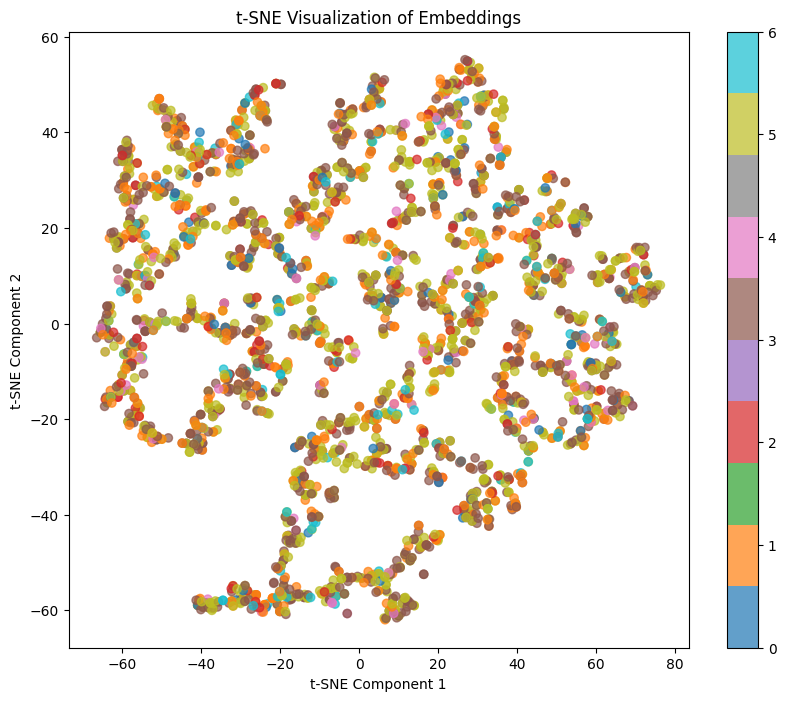

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from sklearn.metrics import classification_report
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root='/content/drive/MyDrive/pure1/data', transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

def triplet_loss(anchor, positive, negative, alpha=0.2):
    pos_dist = torch.sum((anchor - positive) ** 2, dim=-1)
    neg_dist = torch.sum((anchor - negative) ** 2, dim=-1)
    basic_loss = pos_dist - neg_dist + alpha
    loss = torch.mean(torch.max(basic_loss, torch.zeros_like(basic_loss)))
    return loss

resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Identity()

class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

mlp_model = MLPModel(input_size=num_features, hidden_size=512, output_size=num_features)

resnet_model = resnet_model.to(device)
mlp_model = mlp_model.to(device)

optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

num_epochs = 10
embeddings = []
for epoch in range(num_epochs):
    mlp_model.train()
    running_loss = 0.0
    for images, targets in train_loader:
        images = images.to(device)
        targets = targets.to(device)

        features = resnet_model(images)

        batch_size = len(features)
        anchor_indices = torch.randint(0, batch_size, (batch_size,))

        positive_indices = torch.zeros_like(anchor_indices)
        for i, anchor_idx in enumerate(anchor_indices):
            anchor_class = targets[anchor_idx]
            positive_indices[i] = torch.randint(0, len(targets), (1,), dtype=torch.long)
            while targets[positive_indices[i]] != anchor_class:  
                positive_indices[i] = torch.randint(0, len(targets), (1,), dtype=torch.long)

        negative_indices = torch.zeros_like(anchor_indices)
        for i, anchor_idx in enumerate(anchor_indices):
            anchor_class = targets[anchor_idx]
            negative_indices[i] = torch.randint(0, len(targets), (1,), dtype=torch.long)
            while targets[negative_indices[i]] == anchor_class: 
                negative_indices[i] = torch.randint(0, len(targets), (1,), dtype=torch.long)


        anchor = features[anchor_indices]
        positive = features[positive_indices]
        negative = features[negative_indices]

        optimizer.zero_grad()
        anchor_output = mlp_model(anchor)
        positive_output = mlp_model(positive)
        negative_output = mlp_model(negative)

        loss = triplet_loss(anchor_output, positive_output, negative_output)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if epoch == num_epochs-1:
          embeddings.append(anchor_output.detach().cpu().numpy())

    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

torch.save(mlp_model.state_dict(), 'mlp_model.pth')

embeddings = np.concatenate(embeddings, axis=0)

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

embeddings_labels = np.concatenate([target.numpy() for _, target in train_loader])

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=embeddings_labels, cmap='tab10', alpha=0.7)
plt.colorbar()
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()
